# Goldratt's Dice Game

*Paul Bayer, 2019-11-22 v2.0*

Goldratt's Dice Game from his business novel "The Goal" is a classical illustration that dependencies and statistical fluctuations diminish the throughput through a system.

Alex Rogo, the hero of the novel plays a game with five boys:

>*While they get go get the others, I figure out the details. The system I've set up is intended to "process" matches. It does this by moving a quantity of match sticks out of their box, and through each of the bowls in succession. The dice determine how many matches can be moved from one bowl to the next. The dice represent the capacity of each resource, each bowl; the set of bowls are my dependent events, my stages of production. Each has exactly the same capacity as the others, but its actual yield will fluctuate somewhat.*

>*In order to keep those fluctuations minimal, however, I decide to use only one of the dice. This allows the fluctuations to range from one to six. So from the first bowl, I can move to the next bowls in line any quantity of matches ranging from a minimum of one to a maximum of six.*

>*Throughput in this system is the speed at which matches come out of the last bowl, Inventory consists of the total number of matches in all of the bowls at any time. And I'm going to assume that market demand is exactly equal to the average number of matches that the system can process. Production capacity of each resource and market demand are perfectly in balance. So that means I now have a model of a perfectly balanced manufacturing plant.*

>*Five of the boys decide to play. Besides Dave, there are Andy, Ben, Chuck, and Evan. Each of them sits behind one of the bowls. I find some paper and a pencil to record what happens. Then I explain what they're supposed to do.*

>*"The idea is to move as many matches as you can from your bowl to the bowl on your right. When it's your turn, you roll the die, and the number that comes up is the number of matches you can move. Got it?"*

>*They all nod. "But you can only move as many matches as you've got in your bowl. So if you roll a five and you only have two matches in your bowl, then you can only move two matches. And if it comes to your turn and you don't have any matches, then naturally you can't move any."*

>*Eliyahu M Goldratt: The Goal.– 3rd ed, p. 105*

Then Rogo explains to the boys that with the die on average they should pass `3.5` matches through the system, so after twenty cycles they should have got an output of seventy.

![The Dice Game](../src/images/DiceGame.png)

## A Simulation

As Goldratt described it, the game is done in a fixed cycle – no asynchronism here and no need for a discrete-event-simulation. But more realistically it could be seen as an assembly line with buffers between the five workers. The workers take on average 3.5 time units for processing an item and they are admonished to work as fast as possible. 

In [1]:
using Simulate, Distributions, DataFrames, Random

mutable struct Worker
    nr::Int64              # worker number
    input::Channel  
    output::Channel
    dist::Distribution     # distribution for processing time
    perform::Float64       # worker performance factor
    done::Int64            # number of finished items
end

In [2]:
stats(nr, len) = push!(df, (tau(), nr, len))  ## write buffersize to dataframe

function work(w::Worker)
    job = take!(w.input)
    stats(w.nr, length(w.input.data))
    delay!(rand(w.dist)/w.perform)
    put!(w.output, job)
    stats(w.nr+1, length(w.output.data))
    w.done += 1
end

reset!(𝐶)
Random.seed!(1234)                 # seed random number generator
df = DataFrame(time=Float64[], channel=Int[], length=Int[])

C = [Channel(Inf) for i in 1:6]   # create 6 channels
j = reverse(Array(1:8))
for i in 5:-1:2                   # seed channels 2:5 each with 2 inventory items
    put!(C[i], j[(i-1)*2])
    put!(C[i], j[(i-1)*2-1])
end
for i in 9:1000                    # put other 992 jobs into channel 1
    put!(C[1], i)
end

W = [Worker(i, C[i], C[i+1], Uniform(0.5, 6.5), 1.0, 0) for i in 1:5]
for i in 1:5
    process!(SP(i, work, W[i]))
end
run!(𝐶, 1000)

"run! finished with 1390 clock events, 0 sample steps, simulation time: 1000.0"

In [3]:
length(C[6].data)                    # show the length of channel 6

272

In [4]:
1000/272

3.676470588235294

After running for 1000 time units, we got 272 finished items in channel 6, meaning an average cycle time of 3.68, not 3.5 as expected. The expected throughput would have been 286 units, so the line produced only 95% of that, even under "perfect" conditions like unlimited supply, an in-process inventory to start with, infinite buffer sizes, perfectly balanced line and equally performing workers without breaks … What happened?

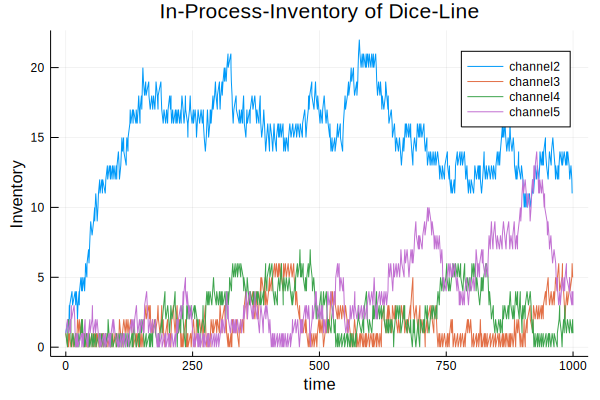

In [5]:
using Plots

function inventory_plot(n::Int64, title)
    for i ∈ 2:n
        d = df[df.channel .== i, :]
        doplot = i == 2 ? plot : plot! 
        doplot(d.time, d.length, label="channel$i")
    end
    title!(title)
    xlabel!("time")
    ylabel!("Inventory")
end
inventory_plot(5, "In-Process-Inventory of Dice-Line")

Here naturally occuring fluctuations in processing times lead to wildly fluctuating buffer sizes, overproduction of worker 1 and also to starvation of other workers down the line when buffers are empty. Let's calculate the inventory of unfinished goods in the line at the end of the simulation run:

In [6]:
1000-length(C[1].data)-length(C[6].data)

26

This gives an average of 6.5 inventory items in channels 2-5. But as we see in the plot, some channels are often empty, leading to some starvation.

## Parametrizing the model

For further investigations we parametrize our model. This is not easily done in graphically oriented simulators, but we can do it with `Simulate.jl`.

As parameters we take:

- `n`: the length of the line (number of, workers)
- `mw`: max WIP-buffer sizes (WIP is work in progress),
- `vp`: variation in processing times from item to item and,
- `vw`: variation between worker performance,
- `d`: the duration of the simulation run

In [7]:
function dice_line(n, mw, vp, vw; d=1000, seed=1234)
    reset!(𝐶)
    Random.seed!(seed)                  # seed random number generator
    global df = DataFrame(time=Float64[], channel=Int[], length=Int[])

    global C = [Channel(mw) for i in 1:n+1] # create n+1 channels with given buffer sizes
    C[1] = Channel(Inf)                 # unlimited sizes for channels 1 and n+1
    C[n+1] = Channel(Inf)
    j = reverse(Array(1:(n-1)*2))
    for i in n:-1:2                     # seed channels 2:(n-1) each with 2 inventory items
        put!(C[i], j[(i-1)*2])
        put!(C[i], j[(i-1)*2-1])
    end
    for i in ((n-1)*2+1):d              # put other jobs into channel 1
        put!(C[1], i)
    end

    wp = rand(vw, n)                    # worker performance
    W = [Worker(i, C[i], C[i+1], vp, wp[i], 0) for i in 1:n]
    for i in 1:n
        process!(SP(i, work, W[i]))
    end
    run!(𝐶, d)
end

dice_line (generic function with 1 method)

## Kanban …

Against too much inventory we have Kanban. So let's introduce maximum buffer sizes of 5 items. We have yet our five perfect workers without varying performance.

In [8]:
using Printf
println(dice_line(5, 5, Uniform(0.5, 6.5), Normal(1,0)))
println(length(C[6].data), " items produced!")
@printf("%5.2f%s capacity utilization", 3.5*length(C[6].data)/10, "%")

run! finished with 1341 clock events, 0 sample steps, simulation time: 1000.0
266 items produced!
93.10% capacity utilization

Uups! We throttled our system further, to an output of 266.

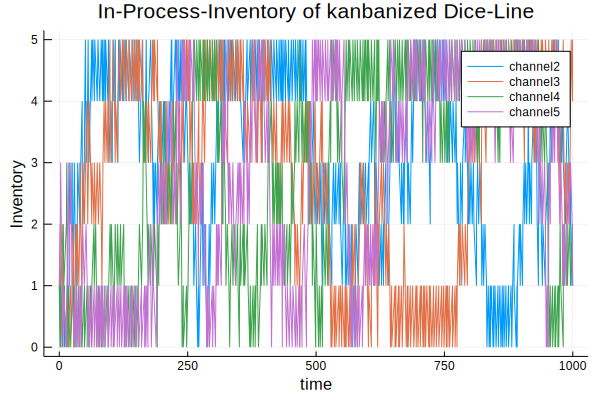

In [9]:
inventory_plot(5, "In-Process-Inventory of kanbanized Dice-Line")

But we got much less inventory in the system. The throttling occurs because with Kanban in-process-inventories get more often to zero. Seemingly Kanban is no solution for our throughput problem but constrains the system further. With Kanban we have reduced unpredictability and instability in inventory. 